### Importación de datos



In [2]:
import pandas as pd

url = "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_1%20.csv"
url2 = "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_2.csv"
url3 = "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_3.csv"
url4 = "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_4.csv"

tienda = pd.read_csv(url)
tienda2 = pd.read_csv(url2)
tienda3 = pd.read_csv(url3)
tienda4 = pd.read_csv(url4)

tienda.head()

,Producto,Categoría del Producto,Precio,Costo de envío,Fecha de Compra,Vendedor,Lugar de Compra,Calificación,Método de pago,Cantidad de cuotas,lat,lon
0,Asistente virtual,Electrónicos,164300.0,6900.0,16/01/2021,Pedro Gomez,Bogotá,4,Tarjeta de crédito,8,4.60971,-74.08175
1,Mesa de comedor,Muebles,192300.0,8400.0,18/05/2022,Beatriz Morales,Medellín,1,Tarjeta de crédito,4,6.25184,-75.56359
2,Juego de mesa,Juguetes,209600.0,15900.0,15/03/2021,Juan Fernandez,Cartagena,1,Tarjeta de crédito,1,10.39972,-75.51444
3,Microondas,Electrodomésticos,757500.0,41000.0,03/05/2022,Juan Fernandez,Cali,4,Nequi,1,3.43722,-76.52250
4,Silla de oficina,Muebles,335200.0,20200.0,07/11/2020,Maria Alfonso,Medellín,5,Nequi,1,6.25184,-75.56359


#1. Análisis de facturación



In [55]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import folium
from IPython.display import display


In [3]:
BASE_RAW = "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/main/base-de-datos-challenge1-latam/"
LOCAL_FILENAMES = ["tienda_1.csv", "tienda_2.csv", "tienda_3.csv", "tienda_4.csv"]
OUTDIR = "./alura_store_outputs"
os.makedirs(OUTDIR, exist_ok=True)

In [4]:
def read_store(index):

    local = Path(LOCAL_FILENAMES[index-1])
    if local.exists():
        df = pd.read_csv(local)
        print(f"Leído local -> {local}")
        return df

In [13]:
def read_store(index):

    local = Path(LOCAL_FILENAMES[index-1])
    if local.exists():
        df = pd.read_csv(local)
        print(f"Leído local -> {local}")
        return df

    candidates = [f"tienda_{index}.csv", f"tienda_{index}%20.csv", f"tienda_{index} .csv"]
    for name in candidates:
        url = BASE_RAW + name
        try:
            df = pd.read_csv(url)
            print(f"Leído remoto -> {url}")
            return df
        except Exception:
            pass
    raise FileNotFoundError(f"No se encontró el archivo para tienda_{index}. Probados: {candidates} y en local: {local}")

In [14]:
def clean_columns(df):
    df = df.copy()
    df.columns = [c.strip().lower().replace(' ', '_') for c in df.columns]
    return df


In [15]:
RENAME_MAP = {
    'calificación': 'calificacion',
    'calificacion_media': 'calificacion',
    'envío': 'costo_envio',
    'envio': 'costo_envio',
    'shipping_cost': 'costo_envio',
    'precio': 'precio',
    'producto': 'producto',
    'categoria': 'categoria',
    'categoria_producto': 'categoria',
    'latitud': 'lat',
    'longitud': 'lon',
    'longitude': 'lon',
    'latitude': 'lat'
}


In [26]:
def normalize_df(df):
    df = df.copy()
    df.columns = [c.strip().lower().replace(' ', '_') for c in df.columns]
    df = df.rename(columns={c: RENAME_MAP.get(c, c) for c in df.columns})
    for col in ['precio','calificacion','costo_envio','lat','lon']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

In [34]:
def normalize_df(df):
    df = df.copy()
    df.columns = [c.strip().lower().replace(' ', '_') for c in df.columns]
    df = df.rename(columns={c: RENAME_MAP.get(c, c) for c in df.columns})

    # Mueve estas líneas DENTRO de la función
    for col in ['precio','calificacion','costo_envio','lat','lon']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    return df

In [35]:
stores = {}
for i in range(1,5):
    df = read_store(i)
    df = normalize_df(df)
    stores[i] = df

Leído remoto -> https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/main/base-de-datos-challenge1-latam/tienda_1%20.csv
Leído remoto -> https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/main/base-de-datos-challenge1-latam/tienda_2.csv
Leído remoto -> https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/main/base-de-datos-challenge1-latam/tienda_3.csv
Leído remoto -> https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/main/base-de-datos-challenge1-latam/tienda_4.csv


# 2. Ventas por categoría

In [36]:
ingresos = {i: stores[i]['precio'].sum(skipna=True) if 'precio' in stores[i].columns else np.nan for i in stores}
ingresos_df = pd.DataFrame.from_dict(ingresos, orient='index', columns=['ingreso_total']).reset_index().rename(columns={'index':'tienda'})
print('\nIngreso total por tienda:')
print(ingresos_df)
ingresos_df.to_csv(os.path.join(OUTDIR, 'ingresos_por_tienda.csv'), index=False)


Ingreso total por tienda:
   tienda  ingreso_total
0       1   1.150880e+09
1       2   1.116344e+09
2       3   1.098020e+09
3       4   1.038376e+09


In [38]:
ventas_por_categoria = {}
for i, df in stores.items():
    if 'categoria' in df.columns:
        agg = df.groupby('categoria').size().reset_index(name='cantidad_ventas').sort_values('cantidad_ventas', ascending=False)
    else:
        # fallback: contar por producto
        agg = df.groupby('producto').size().reset_index(name='cantidad_ventas').sort_values('cantidad_ventas', ascending=False)
    ventas_por_categoria[i] = agg
    agg.to_csv(os.path.join(OUTDIR, f'ventas_categoria_tienda_{i}.csv'), index=False)

print('\nVentas por categoría (top 5 por tienda):')
for i, agg in ventas_por_categoria.items():
    print(f"\nTienda {i} - Top 5")
    print(agg.head(5))


Ventas por categoría (top 5 por tienda):

Tienda 1 - Top 5
            producto  cantidad_ventas
1            Armario               60
48     TV LED UHD 4K               60
33        Microondas               60
40  Secadora de ropa               58
32     Mesa de noche               56

Tienda 2 - Top 5
                     producto  cantidad_ventas
24  Iniciando en programación               65
33                 Microondas               62
7                     Batería               61
38                  Pandereta               58
21          Guitarra acústica               58

Tienda 3 - Top 5
           producto  cantidad_ventas
27    Kit de bancas               57
31  Mesa de comedor               56
11        Cama king               56
41     Set de ollas               55
32    Mesa de noche               55

Tienda 4 - Top 5
                     producto  cantidad_ventas
10                   Cama box               62
15                 Cubertería               59
11           

# 3. Calificación promedio de la tienda


In [39]:
calificaciones = {i: (stores[i]['calificacion'].mean(skipna=True) if 'calificacion' in stores[i].columns else np.nan) for i in stores}
calificaciones_df = pd.DataFrame.from_dict(calificaciones, orient='index', columns=['calificacion_promedio']).reset_index().rename(columns={'index':'tienda'})
print('\nCalificación promedio por tienda:')
print(calificaciones_df)
calificaciones_df.to_csv(os.path.join(OUTDIR, 'calificaciones_por_tienda.csv'), index=False)


Calificación promedio por tienda:
   tienda  calificacion_promedio
0       1               3.976685
1       2               4.037304
2       3               4.048326
3       4               3.995759


# 4. Productos más y menos vendidos

In [40]:
productos_rank = {}
for i, df in stores.items():
    if 'producto' in df.columns:
        agg = df.groupby('producto').agg(cantidad_ventas=('producto','size'), ingreso_total=('precio','sum')).sort_values('cantidad_ventas', ascending=False)
    else:
        agg = pd.DataFrame()
    productos_rank[i] = agg
    agg.to_csv(os.path.join(OUTDIR, f'productos_rank_tienda_{i}.csv'))

In [41]:
for i, agg in productos_rank.items():
    print(f"\nTienda {i} - productos más vendidos (top 5):")
    if agg.shape[0]>0:
        print(agg.head(5))
        print('\n productos menos vendidos (bottom 5):')
        print(agg.tail(5))
    else:
        print("No hay columna 'producto' en el dataset para esta tienda.")


Tienda 1 - productos más vendidos (top 5):
                  cantidad_ventas  ingreso_total
producto                                        
Armario                        60     29462300.0
TV LED UHD 4K                  60    142150200.0
Microondas                     60     34761500.0
Secadora de ropa               58     59062400.0
Mesa de noche                  56     15679600.0

 productos menos vendidos (bottom 5):
                           cantidad_ventas  ingreso_total
producto                                                 
Mochila                                 39      3867200.0
Pandereta                               36      2238900.0
Olla de presión                         35      2629300.0
Celular ABXY                            33     32651000.0
Auriculares con micrófono               33      4730800.0

Tienda 2 - productos más vendidos (top 5):
                           cantidad_ventas  ingreso_total
producto                                                 
Iniciand

# 5. Envío promedio por tienda

In [42]:
costo_envio = {i: (stores[i]['costo_envio'].mean(skipna=True) if 'costo_envio' in stores[i].columns else np.nan) for i in stores}
costo_envio_df = pd.DataFrame.from_dict(costo_envio, orient='index', columns=['costo_envio_promedio']).reset_index().rename(columns={'index':'tienda'})
print('\nCosto de envío promedio por tienda:')
print(costo_envio_df)
costo_envio_df.to_csv(os.path.join(OUTDIR, 'costo_envio_por_tienda.csv'), index=False)


Costo de envío promedio por tienda:
   tienda  costo_envio_promedio
0       1                   NaN
1       2                   NaN
2       3                   NaN
3       4                   NaN


#6) Visualizaciones (al menos 3)

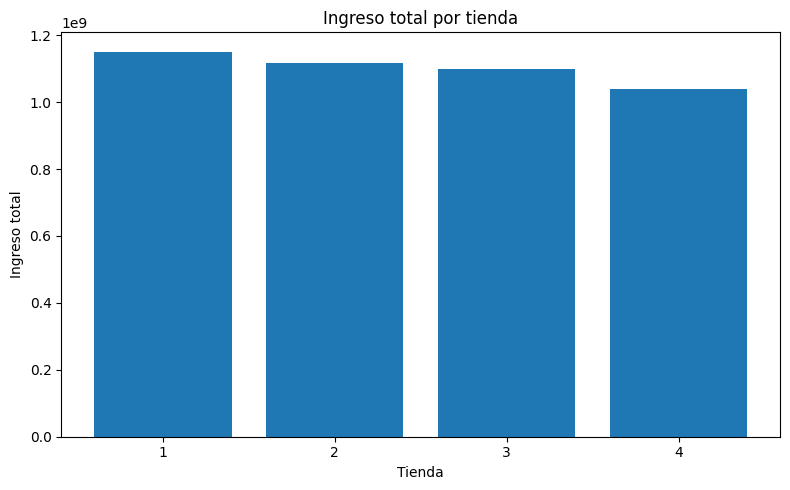

In [43]:
plt.figure(figsize=(8,5))
plt.bar(ingresos_df['tienda'].astype(str), ingresos_df['ingreso_total'])
plt.title('Ingreso total por tienda')
plt.xlabel('Tienda')
plt.ylabel('Ingreso total')
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, 'grafico_ingreso_por_tienda.png'))
plt.show()

# Gráfico 2: Barras horizontales - top categorías por tienda (subplots)

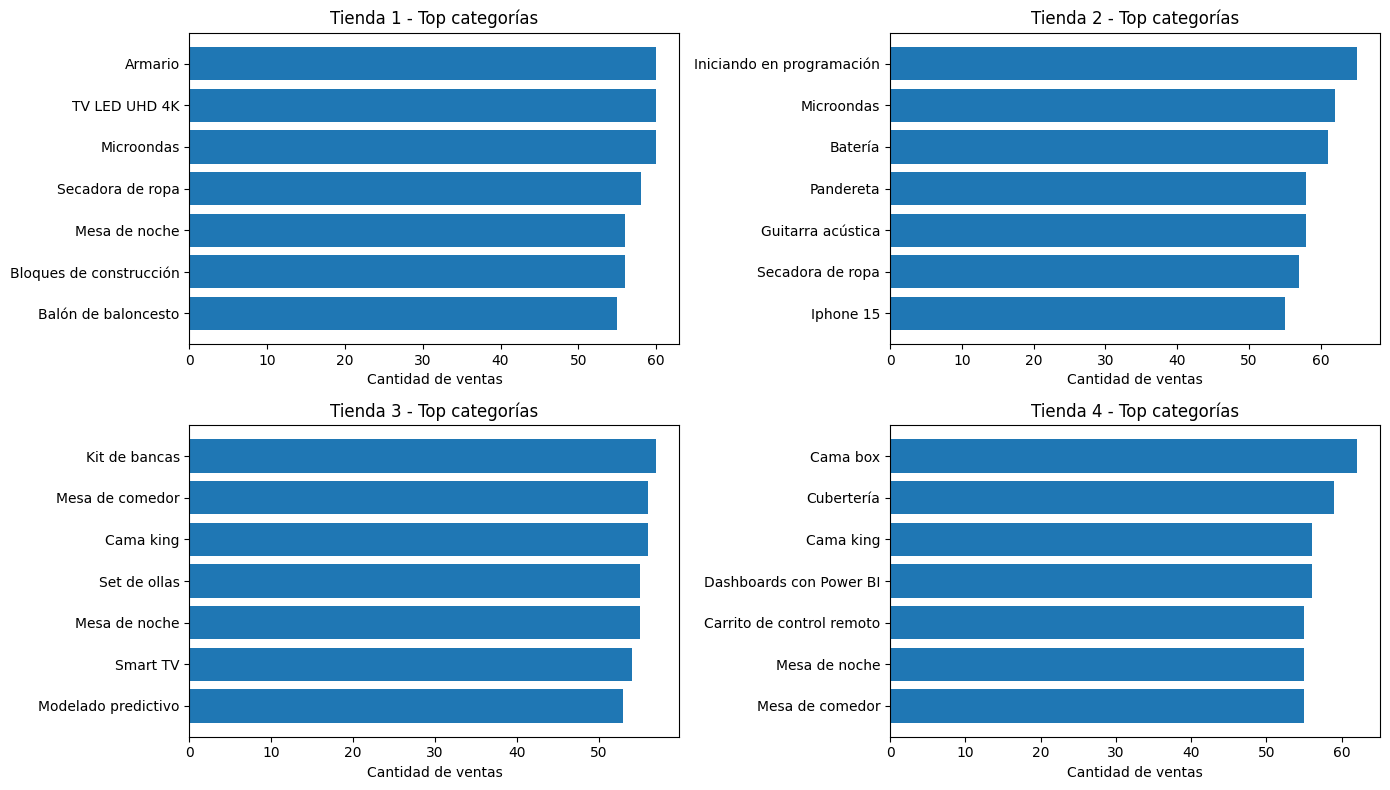

In [48]:
n = len(ventas_por_categoria)
cols = 2
rows = (n + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(14, rows*4))
axes = axes.flatten()
for idx, (i, agg) in enumerate(ventas_por_categoria.items()):
    top = agg.head(7)
    labels = top['categoria'] if 'categoria' in top.columns else top['producto']
    axes[idx].barh(labels, top['cantidad_ventas'])
    axes[idx].invert_yaxis()
    axes[idx].set_title(f'Tienda {i} - Top categorías')
    axes[idx].set_xlabel('Cantidad de ventas')

plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, 'grafico_categorias_por_tienda.png'))
plt.show()

# Gráfico 3: Scatter geográfico (extra) - lat/lon puntos por transacción (tamaño ~ precio)

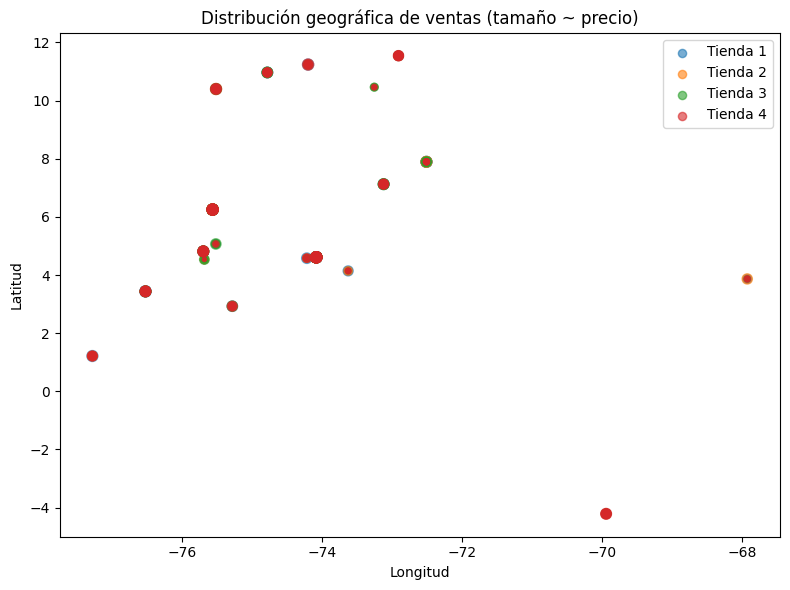

In [50]:
plt.figure(figsize=(8,6))
plotted_any = False
for i, df in stores.items():
    if 'lat' in df.columns and 'lon' in df.columns:
        plotted_any = True
        sizes = df['precio'].fillna(0).clip(lower=0)
        if sizes.max() > 0:
            sizes = (sizes / sizes.max()) * 60 + 5
        else:
            sizes = np.full(len(df), 5)
        plt.scatter(df['lon'], df['lat'], s=sizes, alpha=0.6, label=f'Tienda {i}')
if plotted_any:
    plt.title('Distribución geográfica de ventas (tamaño ~ precio)')
    plt.xlabel('Longitud')
    plt.ylabel('Latitud')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(OUTDIR, 'grafico_geografico_ventas.png'))
    plt.show()
else:
    print('\nNo se encontraron columnas lat/lon en ninguna tienda; omitiendo gráfico geográfico.')


# 7) Informe final (texto resumido)

In [51]:
best = ingresos_df.sort_values('ingreso_total', ascending=False).iloc[0]
worst = ingresos_df.sort_values('ingreso_total', ascending=True).iloc[0]

In [52]:
informe = f"""
INFORME FINAL - Resumen ejecutivo

- Tienda con mayor ingreso: Tienda {int(best['tienda'])} => {best['ingreso_total']:.2f}
- Tienda con menor ingreso: Tienda {int(worst['tienda'])} => {worst['ingreso_total']:.2f}

Recomendación:
Se recomienda que el Sr. Juan priorice vender en la Tienda {int(best['tienda'])}, basada en el mayor ingreso observado. No obstante, antes de una decisión final, recomendamos:
 - Revisar la calificación promedio por tienda (archivo: calificaciones_por_tienda.csv) para asegurar satisfacción de clientes.
 - Revisar el costo de envío promedio (archivo: costo_envio_por_tienda.csv) para confirmar que la rentabilidad no se vea afectada.
 - Evaluar los productos top y si la tienda tiene una dependencia alta en pocas SKUs (riesgo de concentración).

Detalles completos y visualizaciones se guardaron en la carpeta: {OUTDIR}
"""

print(informe)
with open(os.path.join(OUTDIR, 'informe_final.txt'), 'w') as f:
    f.write(informe)



INFORME FINAL - Resumen ejecutivo

- Tienda con mayor ingreso: Tienda 1 => 1150880400.00
- Tienda con menor ingreso: Tienda 4 => 1038375700.00

Recomendación:
Se recomienda que el Sr. Juan priorice vender en la Tienda 1, basada en el mayor ingreso observado. No obstante, antes de una decisión final, recomendamos:
 - Revisar la calificación promedio por tienda (archivo: calificaciones_por_tienda.csv) para asegurar satisfacción de clientes.
 - Revisar el costo de envío promedio (archivo: costo_envio_por_tienda.csv) para confirmar que la rentabilidad no se vea afectada.
 - Evaluar los productos top y si la tienda tiene una dependencia alta en pocas SKUs (riesgo de concentración).

Detalles completos y visualizaciones se guardaron en la carpeta: ./alura_store_outputs



# 8) Extra (opcional): análisis espacial adicional

In [59]:
#has_geo = any(('lat' in df.columns and 'lon' in df.columns) for df in stores.values())
if has_geo:
    # concatenar con identificador de tienda
    rows = []
    for i, df in stores.items():
        if 'lat' in df.columns and 'lon' in df.columns:
            sub = df[['lat','lon','precio']].copy()
            sub['tienda'] = i
            rows.append(sub)
    geo_all = pd.concat(rows, ignore_index=True)
    # crear cuadrícula simple (round lat/lon)
    geo_all['lat_r'] = geo_all['lat'].round(2)
    geo_all['lon_r'] = geo_all['lon'].round(2)
    heat = geo_all.groupby(['lat_r','lon_r']).agg(transacciones=('precio','size'), ingreso_total=('precio','sum')).reset_index()
    heat.to_csv(os.path.join(OUTDIR, 'heatmap_grid_simple.csv'), index=False)
    print('\nSe generó un resumen espacial (grid) en heatmap_grid_simple.csv')
else:
    print('\nNo hay datos geográficos suficientes para el extra.')

print('\nFin del script. Archivos generado(s) en:', OUTDIR)


Se generó un resumen espacial (grid) en heatmap_grid_simple.csv

Fin del script. Archivos generado(s) en: ./alura_store_outputs


In [62]:

def clean_columns(df):
    df = df.copy()
    df.columns = [c.strip().lower().replace(' ', '_') for c in df.columns]
    return df

RENAME_MAP = {
    'calificacion': 'calificacion',
    'calificacion_media': 'calificacion',
    'envio': 'costo_envio',
    'envío': 'costo_envio',
    'shipping_cost': 'costo_envio',
    'precio': 'precio',
    'producto': 'producto',
    'categoria': 'categoria',
    'categoria_producto': 'categoria',
    'latitud': 'lat',
    'longitud': 'lon',
    'longitude': 'lon',
    'latitude': 'lat'
}

def normalize_df(df):
    df = df.copy()
    df.columns = [c.strip().lower().replace(' ', '_') for c in df.columns]
    df = df.rename(columns={c: RENAME_MAP.get(c, c) for c in df.columns})

    # CÓDIGO MOVIDO DENTRO DE LA FUNCIÓN (CORRECCIÓN DEL ERROR)
    for col in ['precio','calificacion','costo_envio','lat','lon']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    return df

# ANÁLISIS GEOESPACIAL CON VISUALIZACIÓN CORREGIDA
has_geo = any(('lat' in df.columns and 'lon' in df.columns) for df in stores.values())

if has_geo:
    # concatenar con identificador de tienda
    rows = []
    for i, df in stores.items():
        if 'lat' in df.columns and 'lon' in df.columns:
            sub = df[['lat','lon','precio']].copy()
            sub['tienda'] = i
            rows.append(sub)

    geo_all = pd.concat(rows, ignore_index=True)
    # crear cuadrícula simple (round lat/lon)
    geo_all['lat_r'] = geo_all['lat'].round(2)
    geo_all['lon_r'] = geo_all['lon'].round(2)

    # CREAR HEATMAP CON FOLIUM
    import folium
    from folium.plugins import HeatMap

    # Calcular centro del mapa
    center_lat = geo_all['lat'].mean()
    center_lon = geo_all['lon'].mean()

    # Crear mapa base
    heat_map = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=12,
        tiles='OpenStreetMap'
    )

    # Preparar datos para heatmap (lat, lon, peso)
    heat_data = [[row['lat'], row['lon'], row['precio']]
                 for idx, row in geo_all.iterrows()
                 if not pd.isna(row['lat']) and not pd.isna(row['lon']) and not pd.isna(row['precio'])]

    # Agregar heatmap
    HeatMap(heat_data,
            min_opacity=0.2,
            max_val=geo_all['precio'].max(),
            radius=15,
            blur=10,
            max_zoom=1).add_to(heat_map)

    # GUARDAR Y MOSTRAR (CORRECCIONES PRINCIPALES)
    heat_map.save(os.path.join(OUTDIR, "heatmap_precios.html"))
    print(f"\n✅ Heatmap guardado en: {OUTDIR}/heatmap_precios.html")
    print("📍 Abre el archivo HTML en tu navegador para ver el mapa interactivo")

    # Para Jupyter Notebook (si estás usándolo)
    try:
        from IPython.display import display
        display(heat_map)
    except:
        pass

    # Crear también cuadrícula resumen
    heat = (geo_all.groupby(['lat_r','lon_r'])
            .agg(transacciones=('precio','size'), ingreso_total=('precio','sum'))
            .reset_index())

    heat.to_csv(os.path.join(OUTDIR, "heatmap_grid_simple.csv"), index=False)
    print(f"📊 Resumen espacial (grid) guardado en: heatmap_grid_simple.csv")

else:
    print("❌ No hay datos geográficos suficientes para el extra.")




✅ Heatmap guardado en: ./alura_store_outputs/heatmap_precios.html
📍 Abre el archivo HTML en tu navegador para ver el mapa interactivo


/tmp/ipython-input-3291166769.py:72: UserWarning: The `max_val` parameter is no longer necessary. The largest intensity is calculated automatically.
  HeatMap(heat_data,


📊 Resumen espacial (grid) guardado en: heatmap_grid_simple.csv
